In [1]:
#load requirements for working with PCs
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import time
import cv2

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
sys.path.append(parent_directory+"/point_cloud_rectification")
from ICET_spherical import ICET
from linear_corrector import LC

from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh

from pillow_heif import register_heif_opener
from matplotlib import pyplot as p
from colmapParsingUtils import *
from scipy.spatial.transform import Rotation as R
import cv2
from lidar_nerf_utils import *

from tqdm import tqdm_notebook as tqdm
from PIL import Image

tf.compat.v1.enable_eager_execution()


%load_ext autoreload
%autoreload 2
%autosave 180
# %matplotlib notebook

2024-07-06 12:28:36.330188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-06 12:28:36.435203: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-06 12:28:36.879410: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-07-06 12:28:36.879478: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-07-06 12:28:37.707165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-06 12:28:37.707428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-06 12:28:37.707616: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-06 12:28:38.054717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-06 12:28:38.055015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Autosaving every 180 seconds


# Load and crop depth image data with arbitrary patch sizes

In [18]:
from remove_motion_basic import linear_correction_old as lc

dir_name = "/media/derm/06EF-127D4/Newer College Dataset/"
experiment_name = "01_short_experiment-20230331T172433Z-009/01_short_experiment/"
fn_gt = dir_name + experiment_name + "ground_truth/registered_poses.csv"
#sec,nsec,x,y,z,qx,qy,qz,qw
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
sensor_poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
sensor_poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
sensor_poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
sensor_poses = np.einsum("nij,jk->nik", sensor_poses, T_CL)
initial_pose = np.linalg.inv(sensor_poses[0]) 
poses_timestamps = seconds * 10e9 + nano_seconds
sensor_poses = np.einsum("ij,njk->nik", np.linalg.inv(sensor_poses[0]), sensor_poses) #TRY COMMENTING OUT...

#get body frame vel to remove motion disortion from training data
vel_world_frame = np.diff(sensor_poses[:,:3,-1], axis = 0)
vel_body_frame = np.linalg.pinv(sensor_poses[1:,:3,:3]) @ vel_world_frame[:,:,None]
vel_body_frame = vel_body_frame[:,:,0]
#smooth out velocity estimates
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
window=50
MAx = moving_average(vel_body_frame[:,0], n = window)
MAy = moving_average(vel_body_frame[:,1], n = window)
MAz = moving_average(vel_body_frame[:,2], n = window)
vel_body_frame = np.array([MAx, MAy, MAz]).T

rot_vel_euls = np.diff(R.from_matrix(sensor_poses[:,:3,:3]).as_euler('xyz'), axis = 0)
idx = np.argwhere(rot_vel_euls > (np.pi))
rot_vel_euls[idx] = 0
idx = np.argwhere(rot_vel_euls < (-np.pi))
rot_vel_euls[idx] = 0

pl = '/media/derm/06EF-127D4/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
show_nth = 5 #10
submap = HD_map[::show_nth]

In [19]:
#  undistort raw point clouds, define patch sizes,
#  take patches about useful regions of the scene, and record poses for each patch 

from time import sleep
#convert gt from xyzquat to homogenous rotation matrix
n_images = 3 #1000 #50 
n_rots = 128 #128    #number of horizontal patches in 360 degrees
n_vert_patches = 1 #8 #number of vertical patches between phimin and phimaxs

# n_cols_to_skip = 0 #comment out for debug
n_cols_to_skip = n_rots // 8 #remove this much from the beginning and end of each scan
                             #   (need to remove parts of frame containing researcher carrying LIDAR)
#Ouster OS1-64
phimin = np.deg2rad(-15.594) #TEST 7/3
phimax = np.deg2rad(17.743)
# phimax = np.deg2rad(15.594) #flipped
# phimin = np.deg2rad(-17.743)
vert_fov = np.rad2deg(phimax-phimin)

poses = np.zeros([n_images*n_rots*n_vert_patches,4,4])
images = np.ones([n_images*n_rots*n_vert_patches, 64//n_vert_patches, 1024//n_rots, 2]) #depth image and raydrop
H, W = images.shape[1:3]

# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True)
# disp = []
# submap_in_map_frame =  (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T #was this
# # submap_in_map_frame =  (np.append(submap, np.ones([len(submap),1]), axis =1).T).T #initial pose already baked in??
# # submap_in_map_frame = submap_in_map_frame @ np.linalg.pinv(T_CL) #TEST
# submap_in_map_frame = submap_in_map_frame[:,:3]
# disp.append(Points(submap_in_map_frame, c = 'gray', r = 2, alpha = 0.25))

redfix_hist = np.zeros([n_images,4,4])#DEBUG

for i in range(n_images):
    print(i) 
    #2nd courtyard
#     idx = i*60 + 1500
    #full loop first courtyard
    idx = i + 7800 
#     idx = i*10 + 7700
    #test simple part of map
#     idx = i*10 + 8400
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)
    
#     # distortion correction ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    m_hat = np.array([-vel_body_frame[idx,0],
                      -vel_body_frame[idx,1],
                      -vel_body_frame[idx,2],
                      -rot_vel_euls[idx,0], #looks good
                      -rot_vel_euls[idx,1],
                      -rot_vel_euls[idx,2]
#                       0,0,0 #rotational velocity is zero-centered (theoretically should cancel out with enough data)
                     ])   
    pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    pc1 = np.flip(pc1, axis = 0)# uncomment to flip and maintain CCW convention used in VICET

    # TEST-- Register undistorted PC against HD Map using ICET to correct issues in ground truth------------------------
    submap_in_pc1_frame = (np.linalg.pinv(sensor_poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T #test
    submap_in_pc1_frame = submap_in_pc1_frame[:,:3]

    initial_guess = tf.constant([0.,0.,0.,0.,0.,0.])
    it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 8, 
       draw = False, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)

    pc1_in_map_frame = (initial_pose @ sensor_poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T #test
    pc1_in_map_frame = pc1_in_map_frame[:,:3]
#     disp.append(Points(pc1_in_map_frame, c = 'red', r = 3, alpha = 0.2))

    pc1_corrected_in_map_frame = (initial_pose @ sensor_poses[idx] @ np.append(it.cloud2_tensor.numpy(), np.ones([len(it.cloud2_tensor.numpy()),1]), axis =1).T).T #test
    pc1_corrected_in_map_frame = pc1_corrected_in_map_frame[:,:3]    
#     disp.append(Points(pc1_corrected_in_map_frame, c = 'blue', r =3, alpha = 0.2))

    #draw red scan corrected by output of ICET
    redFix = np.eye(4)
    redFix[:3,-1] = it.X[:3]
    redFix[:3,:3] = redFix[:3,:3] @ R.from_euler('xyz', [it.X[3], it.X[4], it.X[5]]).as_matrix()
    redfix_hist[i] = redFix
    
    redScanFixed = (redFix @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T
#     redScanFixed = (initial_pose @ sensor_poses[idx] @ np.append(redScanFixed[:,:3], np.ones([len(redScanFixed),1]), axis =1).T).T
    redScanFixed = (sensor_poses[idx] @ np.append(redScanFixed[:,:3], np.ones([len(redScanFixed),1]), axis =1).T).T
#     disp.append(Points(redScanFixed[:,:3], c = 'red', r =3, alpha = 0.2))    
    #----------------------------------------------------------------------------------------------------------------
    
    #convert to depth image
    pc1_spherical = cartesian_to_spherical(pc1).numpy() #[r, theta, phi]
    pcs = np.reshape(pc1_spherical, [-1,64,3])
    pcs = np.flip(pcs, axis = 1)
    raw_data = pcs[:,:,:]
    raw_data = np.transpose(pcs, [1,0,2])

    #destagger depth images (OS1 unit has delay in sensor return bus)
    data = np.zeros([64, 1024])
    for k in range(np.shape(data)[0]//4):
# #         #shift left (nope)
#         data[4*k,:-18] = raw_data[4*k,18:,0]
#         data[4*k+1,:-12] = raw_data[4*k+1,12:,0]
#         data[4*k+2,:-6] = raw_data[4*k+2,6:,0]
#         data[4*k+3,:] = raw_data[4*k+3,:,0]
# #         #shift right -- https://ouster.com/insights/blog/firmware-2-4-industry-standard-protocols-and-improved-alerts
#         data[4*k,:] = raw_data[4*k,:,0]
#         data[4*k+1,6:] = raw_data[4*k+1,:-6,0]
#         data[4*k+2,12:] = raw_data[4*k+2,:-12,0]
#         data[4*k+3,18:] = raw_data[4*k+3,:-18,0]
        # keep centered
        data[4*k,1:-8] = raw_data[4*k,9:,0]
        data[4*k+1,1:-2] = raw_data[4*k+1,3:,0]
        data[4*k+2,4:] = raw_data[4*k+2,:-4,0]
        data[4*k+3,10:] = raw_data[4*k+3,:-10,0]
#         #TEST-- no shift
#         data = raw_data[:,:,0]
    
    data = np.flip(data, axis =1) #do not comment out

    for j in range(n_rots):
        for k in range(n_vert_patches):
            #get cropped depth image ~~~~~~~~~~~~~~~~~~~~    
            image_width = 1024//n_rots
            image_height = 64//n_vert_patches
            pcs = data[k*image_height:(k+1)*image_height,j*image_width:(j+1)*image_width] #crop vertically and horizontally
            #save depth information to first channel
            images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] = pcs
            #save raydrop mask to 2nd channel
            a = np.argwhere(abs(pcs) < 1)
            images[k+(j+(i*n_rots))*n_vert_patches, a[:,0],a[:,1],1] = 0

            #get transformation matrix ~~~~~~~~~~~~~~~~~~
            #centers origin at actual origin of HD map 
            #  need to comment out line in above cell normazlizing sensor_poses w.r.t. first pose
            rotm = sensor_poses[idx] @ redfix_hist[i]
            rotm = np.linalg.pinv(initial_pose) @ rotm

            rotm[:3,-1] = np.array([-rotm[2,-1], -rotm[0,-1], rotm[1,-1]])

            #orient yellow (-z) pointing forward
            fix = np.array([[0,0,1],
                            [1,0,0],
                            [0,1,0]])
            rotm[:3,:3] = rotm[:3,:3] @ fix
            
            swap_axis_matrix = np.array([[0, 0, 1],
                                         [1, 0, 0],
                                         [0, 1, 0]])
#             flip_axis_matrix = np.diag([-1,1,-1]) #was this
            flip_axis_matrix = np.diag([1,1,-1]) # better ---> corrects flipping z issue when rendering
            rotm[:3,:3] = flip_axis_matrix @ swap_axis_matrix @ rotm[:3,:3] 

            #center camera horizontally in each patch
            crop_angle = j*(2*np.pi/n_rots) + (np.pi/n_rots)

            #account for the fact that sensor points back and to the left
            rotm_crop = R.from_euler('xyz', [0,-crop_angle,0]).as_matrix()

            rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

            #courtyard1
            rotm[2,-1] += 45 #translate above xy plane
            rotm[1,-1] += 30 #shift towards positive x
#             rotm[0,-1] += 2 #TEST -- shift up just a little
#             rotm[2,-1] += 120 #courtyard2

            #Linearly scale down translations and ranges ~~~~~~~~~~~~~~~~~~~
            rotm[:3,-1] *= 0.005 #0.005 #0.02 #0.05
            images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] *= 0.005 #0.02 #0.005 #0.05
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            # recenter (when using x0.005)
            rotm[2,-1] += 0.25 #translate above xy plane
            rotm[1,-1] += 0.25 #shift towards positive x
            rotm[0,-1] += 0.01 #TEST -- shift up just a little
            
#             poses[j+(i*n_rots)] = rotm
            poses[k+(j+(i*n_rots))*n_vert_patches] = rotm

images = images.astype(np.float32)
poses = poses.astype(np.float32)

print("num poses:", len(poses))

# # Remove patches where sensor is occluded by person holding lidar ~~~~~~~~~~
#calculte how many columns of patches we need to skip at the beginning and end of each scan to avoid
print("n_rots:", n_rots)
# n_cols_to_skip = 0 #debug
print("n_cols_to_skip:", n_cols_to_skip)

bad_idx = np.zeros([0,n_rots - 2*n_cols_to_skip])
a = np.linspace(0,n_rots*n_images*n_vert_patches-1,n_rots*n_images*n_vert_patches)
print(np.shape(a))
for i in range(n_vert_patches*n_cols_to_skip):
    bad_i_left = a[i::n_rots*n_vert_patches]
    bad_idx = np.append(bad_idx, bad_i_left)
#     print("\n bad_idx_left:", bad_i_left)

    bad_i_right = a[(i+n_vert_patches*(n_rots-n_cols_to_skip))::n_rots*n_vert_patches]
    bad_idx = np.append(bad_idx, bad_i_right)
#     print("\n bad_idx_right:", bad_i_right)
    
bad_idx = np.sort(bad_idx)
all_idx = np.linspace(0,n_rots*n_images*n_vert_patches-1,n_rots*n_images*n_vert_patches)
good_idx = np.setdiff1d(all_idx, bad_idx).astype(int)

# print(good_idx)

images = images[good_idx,:,:,:]
poses = poses[good_idx,:,:]
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# test on one only
testimg, testpose = images[-1], poses[-1]
images = images[:-1,...,:3]
poses = poses[:-1]

# plt.show(disp, "01 Short Experiment Frame #" + str(idx))
# ViewInteractiveWidget(plt.window)

0
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([ 0.25363594  0.06432783 -0.02580112  0.00427418  0.00923072 -0.02989409], shape=(6,), dtype=float32)
1
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([ 0.11319958  0.08248238 -0.01370145  0.00526397  0.00808255 -0.00030679], shape=(6,), dtype=float32)
2
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([ 0.21538554  0.10003486 -0.00827829  0.00272415  0.00778185 -0.01537846], shape=(6,), dtype=float32)
num poses: 384
n_rots: 128
n_cols_to_skip: 16
(384,)


In [20]:
#draw subsequent scans aligned using poses with redfix
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

colors = ['red', 'orange', 'yellow', 'green', 'blue']

for i in range(3):
    idx = i + 7800
#     idx = i*10 + 8400
    
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)
#     # distortion correction ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    m_hat = np.array([-vel_body_frame[idx,0],
                      -vel_body_frame[idx,1],
                      -vel_body_frame[idx,2],
                      -rot_vel_euls[idx,0], #looks good
                      -rot_vel_euls[idx,1],
                      -rot_vel_euls[idx,2]
#                       0,0,0 #rotational velocity is zero-centered (theoretically should cancel out with enough data)
                     ])   
    pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~        
    #centers origin at actual origin of HD map 
    #  need to comment out line in above cell normazlizing sensor_poses w.r.t. first pose
    rotm = sensor_poses[idx] @ redfix_hist[i]
#     rotm = np.linalg.pinv(sensor_poses[7700]) @ rotm #look in terms of keyframe
    rotm = np.linalg.pinv(sensor_poses[7700]) @ rotm
#     rotm = np.linalg.pinv(initial_pose) @ rotm #look in terms of world origin
    
    
    pc1_aligned = (rotm @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T    
        
    disp.append(Points(pc1_aligned[:,:3], c = colors[i], r = 3.5, alpha = 0.25))
    
    disp.append(Points(rotm[:3,-1][None,:], c = 'k', r = 5))

plt.show(disp, "Training Data Sample")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=600, layout=Layout(height='auto', width='100%'), width=600)

# TODO

* For each "keyframe" scan:
    * align $n$ previous scans using ICET
    * cast cones about each point in scan, get radial distances from all points that fall within cone
    * use distances to construct CDF
    * use CDF to train NeRF
   

In [21]:
for i in range(3):
    start_idx = 7800
    idx = i + start_idx
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)
    print(np.shape(pc1))
#     # distortion correction ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    m_hat = np.array([-vel_body_frame[idx,0],
                      -vel_body_frame[idx,1],
                      -vel_body_frame[idx,2],
                      -rot_vel_euls[idx,0], #looks good
                      -rot_vel_euls[idx,1],
                      -rot_vel_euls[idx,2]
                     ])   
    pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~        
    #centers origin at actual origin of HD map 
    rotm = sensor_poses[idx] @ redfix_hist[i]
    rotm = np.linalg.pinv(sensor_poses[start_idx]) @ rotm #look in terms of keyframe
#     rotm = np.linalg.pinv(initial_pose) @ rotm #look in terms of world origin
    
    pc1_aligned = (rotm @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T    
    
    disp.append(Points(pc1_aligned[:,:3], c = colors[i], r = 3.5, alpha = 0.25))
    
    disp.append(Points(rotm[:3,-1][None,:], c = 'k', r = 5))

    if i == 0:
        scan1 = pc1_aligned[:,:3]
    if i == 1:
        scan2 = pc1_aligned[:,:3]
    if i == 2:
        scan3 = pc1_aligned[:,:3]

(65536, 3)
(65536, 3)
(65536, 3)


In [22]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

disp.append(Points(scan1, c='red', r = 3, alpha = 0.5))
disp.append(Points(scan2, c='green', r = 3, alpha = 0.5))
disp.append(Points(scan3, c='blue', r = 3, alpha = 0.5))

plt.show(disp, "aligned scans")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=600, layout=Layout(height='auto', width='100%'), width=600)

In [23]:
def gen_scan_from_map(hd_map, p, res = [64, 1024], 
                      phimin = np.pi/2 + np.deg2rad(-17.743), 
                      phimax = np.pi/2 + np.deg2rad(15.594), 
                      tol = 0.001, use_IP = True):
    """p = pose, homogemous coordinates"""
        
    #align hd map about origin according to pose
    if use_IP:
        centered_map = (np.linalg.pinv(p) @ initial_pose @ np.append(hd_map, np.ones([len(hd_map),1]), axis =1).T).T
    else:
        centered_map = (np.linalg.pinv(p) @ np.append(hd_map, np.ones([len(hd_map),1]), axis =1).T).T
    centered_map_s = cartesian_to_spherical(centered_map)
    
    #remove points outside vertical fov
    centered_map_s = centered_map_s[centered_map_s[:,2] > phimin]
    centered_map_s = centered_map_s[centered_map_s[:,2] < phimax]
    centered_map_s = centered_map_s[centered_map_s[:,0]< 100]
    
    #test looking at narrow azimuth range
    #sort by azimuth angle
    centered_map_s = centered_map_s.numpy()
    sorted_indices = centered_map_s[:,1].argsort() #[-pi, pi]
    centered_map_s = centered_map_s[sorted_indices]

    #just keep points that are within tol of a phi angle
    scan = np.zeros([0,3])
    gp = np.linspace(phimin, phimax, res[0]) #good phis

    #loop through each horizontal angle
    for j in range(res[1]):
        centered_map_s_slice = centered_map_s[centered_map_s[:,1] > (-np.pi + (2*np.pi*j/res[1]))]
        centered_map_s_slice = centered_map_s_slice[centered_map_s_slice[:,1] < (-np.pi + (2*np.pi*(j+1)/res[1]))]
#         print(j)
        
        #loop through each elevation angle
        for i in range(res[0]):
            tol_temp = tol
            good = np.zeros([0,3])
            count = 0
            #gradually up tolerance about sampling angle until sufficient number of points are captured in scan line
            # or increasing tolerance no longer helps
            while (np.shape(good)[0] < (3*1024)//(res[1])):
                good = centered_map_s_slice[abs(centered_map_s_slice[:,2] - gp[i]) < tol_temp ]
                tol_temp *= 1.3
                if count > 5:
                    np.zeros([0,3])
                    break
                count += 1

            #add closest point to scan, give it theoretical target elevation and azimuth
            if len(good) >= 1:
                best_r = min(good[:,0])
            else:
                best_r = 0
            best_point_s = np.array([[best_r, -np.pi + np.pi/res[1] + (2*np.pi*j/res[1]), gp[i]]]) #[r, elev, azim]
            scan = np.append(scan, best_point_s, axis = 0)
        
    scan = spherical_to_cartesian(scan)
    return scan

In [24]:
def create_random_scan(HD_map, scan_dims = [64,1024], phimin = np.deg2rad(-15.594), phimax = np.deg2rad(17.743)):
    phimin += np.pi/2 
    phimax += np.pi/2
    
    newPose = np.eye(4)
    #[-53, -5]x, [-10,10]y, [0.5,3]z
    trans = np.array([-43,-5,0.5]) + np.array([28,10,2.5])*np.random.rand(3) #just center of courtyard
#     trans = np.array([-53,-10,0.5]) + np.array([48,20,2.5])*np.random.rand(3) #full space
    trans_mapframe = R.from_euler('xyz', [0,0,np.pi/4]).as_matrix() @ trans #rotate to map coordinate system
    newPose[0:3,-1] = trans_mapframe
    simulated_scan = gen_scan_from_map(HD_map, newPose, res = scan_dims, phimin = phimin, phimax = phimax)[:,:3]
    # simulated_scan = gen_scan_from_map(HD_map, newPose, res = scan_dims, phimin = np.pi/2 + np.deg2rad(-20), phimax = np.pi/2 + np.deg2rad(10))[:,:3] #debug
    
#     simulated_scan = None #temp for debug only
    
    return(newPose, simulated_scan)

# cone cast scan2 in scan1 frame 

In [25]:
# print(np.shape(scan2))
# print(np.shape(scan3))

In [26]:
newPose = np.eye(4)
# newPose[:3,:3] = 0
# scan2 = scan2[abs(scan2[:,0]) > 0.1]#remove points at the origin

simulated_scan = gen_scan_from_map(scan2, newPose, res = [64,1024], use_IP = False)[:,:3]

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True)
disp = []
disp.append(Points(scan1, c = 'red', r =3))
disp.append(Points(scan2, c = 'green', r =3))
disp.append(Points(simulated_scan, c = 'black', r = 4, alpha = 1.))
plt.show(disp, "ray casting scan2 in scan1 frame" + str(idx))
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=600, layout=Layout(height='auto', width='100%'), width=600)

In [39]:
#convert to depth image
pc1_spherical = cartesian_to_spherical(scan1).numpy() #[r, theta, phi]
# pc1_spherical = cartesian_to_spherical(scan2).numpy() #[r, theta, phi] #DEBUG
pcs = np.reshape(pc1_spherical, [-1,64,3])
pcs = np.flip(pcs, axis = 1)
raw_data = pcs[:,:,:]
raw_data = np.transpose(pcs, [1,0,2])
#destagger depth images (OS1 unit has delay in sensor return bus)
data = np.zeros([64, 1024])
for k in range(np.shape(data)[0]//4):
    data[4*k,1:-8] = raw_data[4*k,9:,0]
    data[4*k+1,1:-2] = raw_data[4*k+1,3:,0]
    data[4*k+2,4:] = raw_data[4*k+2,:-4,0]
    data[4*k+3,10:] = raw_data[4*k+3,:-10,0]
scan1_image = np.flip(data, axis =1) #do not comment out
# scan1_image = np.flip(scan1_image, axis = 0) #test

#convert simulated scan as well
ss_spherical = cartesian_to_spherical(simulated_scan)
pcs = np.reshape(ss_spherical, [-1,64,3])
pcs = np.flip(pcs, axis = 1)
ss_image = np.transpose(pcs, [1,0,2])
ss_image = np.nan_to_num(ss_image, nan=0.0)[:,:,0]
#get ss_image to start at the same rotation angle as keyframe scan
#account for shift from staggering
# right_half = np.append(ss_image[:,8:512].copy(), np.zeros([64, 8]), axis = 1)
# left_half = np.append(np.zeros([64, 8]), ss_image[:,512:-8].copy(), axis = 1)
right_half = ss_image[:,:512].copy()
left_half = ss_image[:,512:].copy()

ss_image[:,512:] = right_half
ss_image[:,:512] = left_half
print(np.shape(ss_image))
print(np.shape(scan1_image))

(64, 1024)
(64, 1024)


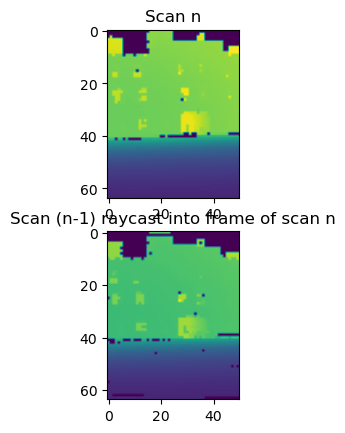

In [41]:
fig, ax = p.subplots(2,1)
ax[0].set_title("Scan n")
ax[1].set_title("Scan (n-1) raycast into frame of scan n")

# ax[0].imshow(scan1_image)
# ax[1].imshow(ss_image)
# ax[0].imshow(np.flip(scan1_image[:,512:1024], axis = 0))
# ax[1].imshow(np.flip(ss_image[:,512:1024], axis = 0))
ax[0].imshow(np.flip(scan1_image[:,800:850], axis = 0))
ax[1].imshow(np.flip(ss_image[:,800:850], axis = 0))
# ax[2].imshow(np.flip(scan1_image[:,500:550]-ss_image[:,500:550], axis = 0))

# Suppress additional returns if angle is too oblique (hurts ground plane)

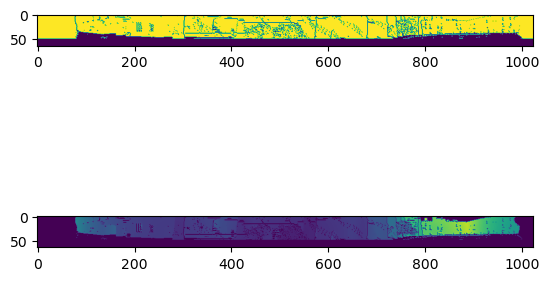

In [47]:
horiz_grad = np.gradient(ss_image)[1] 
vert_grad = np.gradient(ss_image)[0] 

horiz_grad2 = np.gradient(np.gradient(ss_image)[1])[1] 
horiz_grad2 = horiz_grad2 > 0.1

mask = (1 - (horiz_grad > 0.5)) * (1 - (vert_grad > 0.3)) + horiz_grad2
mask = mask >= 1

#hard fix-- remove ring around base via threshold
mask[:15,:] = 0 

fig, ax = p.subplots(2)
# ax[0].imshow(np.flip(mask[:,300:600], axis = 0))
# ax[1].imshow(np.flip(ss_image*mask, axis = 0)[:,300:600])
ax[0].imshow(np.flip(mask[:,:], axis = 0))
ax[1].imshow(np.flip(ss_image*mask, axis = 0)[:,:])

## Construct CDF function for each pixel in scan n

In [48]:
print(scan1_image[20,500])
print((mask*ss_image)[20,500])

#LOAD [-17.5,15]x1000, @0.005
# np.save("/home/derm/Desktop/posesM17P15.npy", poses)
# np.save("/home/derm/Desktop/imagesM17P15.npy", images)
poses = np.load("/home/derm/Desktop/posesM17P15.npy")
images = np.load("/home/derm/Desktop/imagesM17P15.npy")

8.491015508752627
8.238304134226013


In [49]:
near = 0
far = 1
N_samples = 128

n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #8 #number of vertical patches between phimin and phimax
H = 64 // n_vert_patches
W = 1024 // n_rots

phimin = np.deg2rad(-17.743) #flipped-- used for best synthetic-- WAS using this for best real data
phimax = np.deg2rad(15.594) #flipped
phivals = np.linspace(phimin, phimax, 64)#new (correct) way to bin elevation angles
img_i = np.random.randint(images.shape[0])
idx_first=len(phivals) - (img_i%(n_vert_patches))*(64//n_vert_patches)-1
idx_second= (len(phivals)- ((img_i+1)%(n_vert_patches))*(64//n_vert_patches))%len(phivals)
phimin_patch = phivals[idx_first]
phimax_patch = phivals[idx_second]    

pose = tf.cast(poses[0], tf.float32)

#get ray origins and ray directions
rays_o, rays_d = get_rays(H, W, pose, phimin_patch, phimax_patch)

s1 = scan1_image * 0.005

z_vals = tf.linspace(near, far, N_samples)  #IMPORTANT NOTE: z_vals must be in ascending order 
z_vals = tf.cast(z_vals, tf.float32)
z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
z_vals = z_vals[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)

print(np.shape(z_vals))
# print(z_vals[0,0,:,0])

(64, 8, 128, 1)


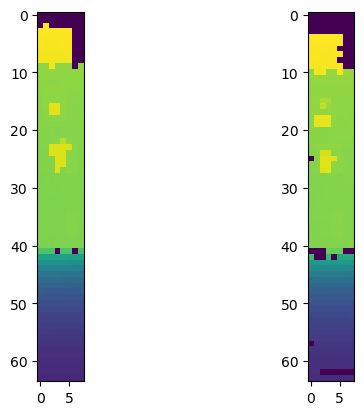

In [50]:
#crop scan 1 image and see where it falls wrt each z val 
scan1_image_cropped = scan1_image[:, 800:808]*0.005
ss_image_cropped = ss_image[:, 800:808]*0.005
# ss_image_cropped = mask[:, 800:808]*ss_image[:, 800:808]*0.005

# print(np.shape(scan1_image_cropped))
fig, ax = p.subplots(1,2)
ax[0].imshow(np.flip(scan1_image_cropped, axis = 0))
ax[1].imshow(np.flip(ss_image_cropped, axis = 0))

cdf1 = scan1_image_cropped[:,:,None] < z_vals[:,:,:,0]
cdf2 = ss_image_cropped[:,:,None] < z_vals[:,:,:,0]

# Combine multiple range images into single PDF

#### Need to be careful dealing with non-returns from cone-cast scans!
* subtract starting val to ignore rays at 0, and rescale

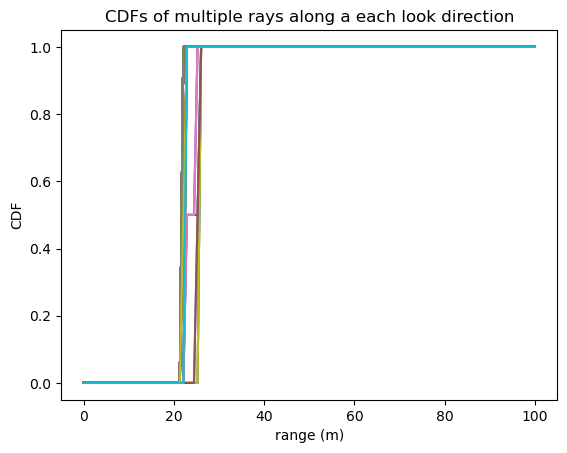

In [53]:
# print(np.shape(cdf1[0,0,:]))
combined = tf.cast(cdf1[25:40,:,:], tf.float32) + tf.cast(cdf2[25:40,:,:], tf.float32)

#subtract out initial value of cdf2 to remove rays that didn't get a collision from prev scan
# print(np.shape(combined))
# print(np.shape(tf.cast(cdf2[:,:,0][:,:,None], tf.float32)))
combined -= tf.cast(cdf2[25:40,:,0][:,:,None], tf.float32)

#re-normalize to [0,1]
num_useful_returns = (tf.math.reduce_max(combined, axis = -1))[:,:,None]
# print(np.shape(num_useful_returns), num_useful_returns)
combined = combined/num_useful_returns
combined = tf.reshape(combined, [-1,128])

# print(np.shape(combined))

fig, ax = p.subplots()
ax.set_title("CDFs of multiple rays along a each look direction")
ax.set_xlabel("range (m)")
ax.set_ylabel("CDF")
ax.plot(np.linspace(0,100,128),combined.numpy().T);